<font size=5> **[넷플릭스 데이터를 활용한 추천 시스템 개발]** </font>
- netflix_titles.csv 데이터를 활용하여 주요 데이터 시각화 및 추천 시스템을 개발하시오
- 각 마크다운 셀의 내용을 참고하여 비어있는 코드 셀에 코드를 작성합니다.
- 제시된 아웃풋은 참고이며 반드시 동일할 필요는 없습니다.
- <font color='red'><b>빨간색</b></font>으로 표기된 영역은 이미 작성되어 있는 코드로 그대로 활용하시면 됩니다.

# 데이터 로딩

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
netflix = pd.read_csv('./netflix_titles.csv')

In [3]:
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


# 주요 데이터 시각화

## TV Show vs Movies (콘텐츠 타입) 막대 그래프

In [5]:
contents_type= pd.DataFrame(netflix['type'].value_counts()).sort_values('type')
contents_type

,type
TV Show,2410
Movie,5377


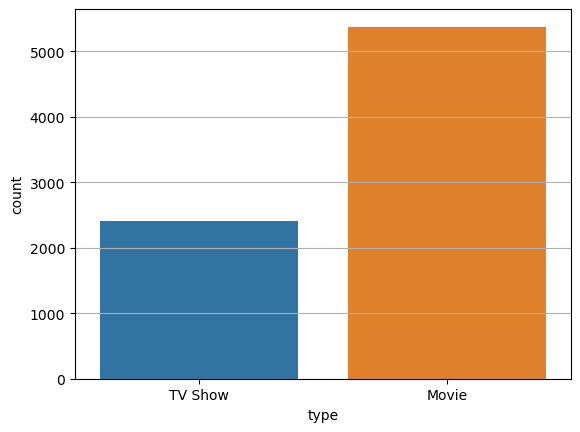

In [6]:
sns.barplot(data= contents_type, x= contents_type.index, y='type')
plt.xlabel('type')
plt.ylabel('count')
plt.grid(True, axis='y')
plt.show()

## 제작 국가별 수평 막대 그래프
- 결측 값 확인 및 결측 값을 포함한 레코드 삭제
- 2개 이상의 제작국가 값을 가지고 있는 레코드는 ‘,’를 기준으로 분류하여 카운팅 한다.
- 상위 10개국에 대한 막대그래프를 그린다.

In [7]:
netflix.shape

(7787, 12)

In [8]:
np.sum(netflix['country'].isna())

507

In [9]:
country = netflix['country'].dropna()

In [10]:
country= country.str.split(', ')
country

0                                                [Brazil]
1                                                [Mexico]
2                                             [Singapore]
3                                         [United States]
4                                         [United States]
                              ...                        
7781                                      [United States]
7782    [Sweden, Czech Republic, United Kingdom, Denma...
7783                                              [India]
7785                                          [Australia]
7786              [United Kingdom, Canada, United States]
Name: country, Length: 7280, dtype: object

In [11]:
country_count = dict()
for x in country:
    for word in x:
        if word not in country_count.keys():
            country_count[word] = 1
        if word in country_count.keys():
            country_count[word] += 1

In [12]:
country_count_df = pd.DataFrame(pd.Series(country_count), columns=['count']).sort_values('count',ascending=False).head(10)
country_count_df

,count
United States,3297
India,991
United Kingdom,723
Canada,413
France,350
Japan,288
Spain,216
South Korea,213
Germany,200
Mexico,155


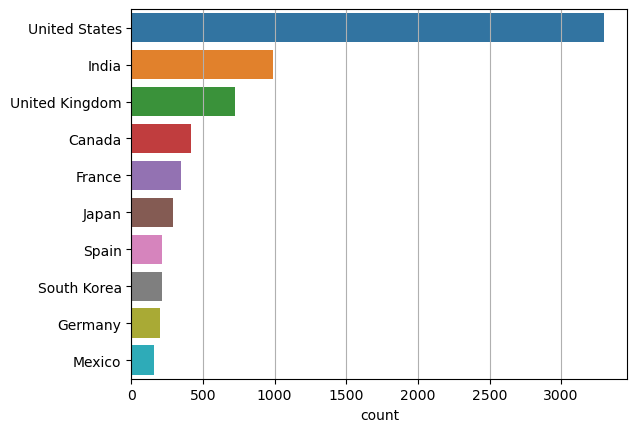

In [13]:
sns.barplot(data= country_count_df, x= 'count', y= country_count_df.index)
plt.grid(True, axis = 'x')
plt.show()

# 제목, 장르, 요약내용 특성 값을 기반으로 한 콘텐츠 기반 필터링 추천

## 데이터 전처리

### 추천 알고리즘 분석과 관련한 컬럼만 추출
- 추출 대상 컬럼: 'show_id', 'title', 'listed_in', 'description'    

In [14]:
netflix_df = netflix[['show_id', 'title', 'listed_in', 'description']]

In [15]:
netflix_df.head()

,show_id,title,listed_in,description
0,s1,3%,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,7:19,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,23:59,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,9,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,21,Dramas,A brilliant group of students become card-coun...


- 처리결과
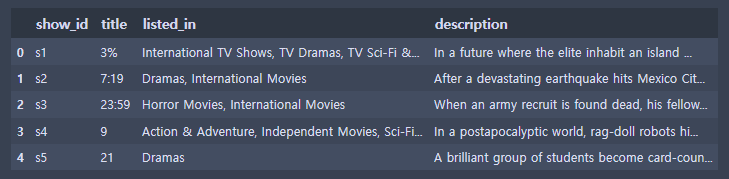

### 형태소 분석 - 1
- title, listed_in, description 컬럼에 있는 텍스트 데이터의 모든 단어를 소문자로 변경
    - title 컬럼에 대한 형태소 분석 결과는 새로운 컬럼인 'title_list'로 생성
- nltk (Natural Language Tookit)의 word_tokenize 함수를 활용하여 단어를 공백문자를 기준으로 분할한다
- <font color='red'><b>[주의]</b></font>: 위 코드에서 분석에 필요한 컬럼만 추출해서 만든 DataFrame 객체의 변수 이름을 **netflix_df**로 한다.

In [16]:
# 파이썬 경고 메세지 출력 안하기
import warnings
warnings.filterwarnings(action='ignore')

import nltk
# 구두점: 글의 여러 가지 경계를 구분하기 위해 사용되는 반점(,), 온점(.), 물음표(?), 쌍점( : ), 쌍반점(;), 줄표(--), 붙임표(-) 등의 부호
# 불용어: 문장을 분석하는데 큰 의미가 없는 문자열
nltk.download('stopwords') # 구두점 사전 다운로드
nltk.download('punkt') # 불용어 사전 다운로드

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
netflix_df['title_list'] = netflix_df['title'].str.lower()
netflix_df['listed_in']= netflix_df['listed_in'].str.lower()
netflix_df['description']= netflix_df['description'].str.lower()

In [18]:
netflix_df.head()

,show_id,title,listed_in,description,title_list
0,s1,3%,"international tv shows, tv dramas, tv sci-fi &...",in a future where the elite inhabit an island ...,3%
1,s2,7:19,"dramas, international movies",after a devastating earthquake hits mexico cit...,7:19
2,s3,23:59,"horror movies, international movies","when an army recruit is found dead, his fellow...",23:59
3,s4,9,"action & adventure, independent movies, sci-fi...","in a postapocalyptic world, rag-doll robots hi...",9
4,s5,21,dramas,a brilliant group of students become card-coun...,21


In [19]:
netflix_df.dtypes

show_id        object
title          object
listed_in      object
description    object
title_list     object
dtype: object

In [20]:
major_columns = ['title_list', 'listed_in', 'description']

In [21]:
for col in major_columns:
    netflix_df[col]= netflix_df[col].apply(nltk.word_tokenize)

In [22]:
netflix_df.head()

,show_id,title,listed_in,description,title_list
0,s1,3%,"[international, tv, shows, ,, tv, dramas, ,, t...","[in, a, future, where, the, elite, inhabit, an...","[3, %]"
1,s2,7:19,"[dramas, ,, international, movies]","[after, a, devastating, earthquake, hits, mexi...",[7:19]
2,s3,23:59,"[horror, movies, ,, international, movies]","[when, an, army, recruit, is, found, dead, ,, ...",[23:59]
3,s4,9,"[action, &, adventure, ,, independent, movies,...","[in, a, postapocalyptic, world, ,, rag-doll, r...",[9]
4,s5,21,[dramas],"[a, brilliant, group, of, students, become, ca...",[21]


- 처리결과
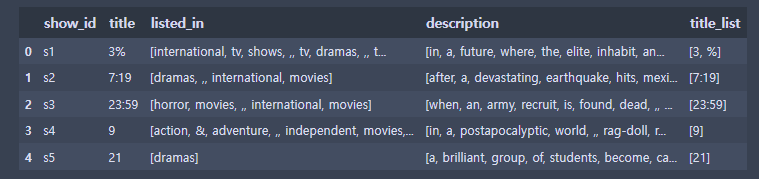

### 형태소 분석 - 2
- 단어별로 토큰 된 title_list, listed_in, description 컬럼 데이터 중 nltk 라이브러리의 stopwords 패키지를 활용하여 불용어(관사, 조사, 전치사 등 단어로서 의미가 없는 단어)를 제거한다.

In [23]:
from nltk.corpus import stopwords
from string import punctuation

# list_stopwords: 구두점 및 불용어 목록
list_stopwords = set(stopwords.words('english') + list(punctuation))

# title, listed_in, description 컬럼 데이터에서 구두점 및 불용어 단어를 제거 코드 작성

In [24]:
for col in major_columns:
    netflix_df[col] = netflix_df[col].apply(
        lambda x: [word for word in x if word not in list_stopwords])

In [25]:
netflix_df.head()

,show_id,title,listed_in,description,title_list
0,s1,3%,"[international, tv, shows, tv, dramas, tv, sci...","[future, elite, inhabit, island, paradise, far...",[3]
1,s2,7:19,"[dramas, international, movies]","[devastating, earthquake, hits, mexico, city, ...",[7:19]
2,s3,23:59,"[horror, movies, international, movies]","[army, recruit, found, dead, fellow, soldiers,...",[23:59]
3,s4,9,"[action, adventure, independent, movies, sci-f...","[postapocalyptic, world, rag-doll, robots, hid...",[9]
4,s5,21,[dramas],"[brilliant, group, students, become, card-coun...",[21]


- 처리결과
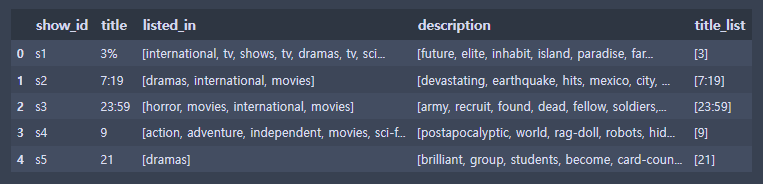

### <font color='red'> 형태소 분석 - 3 </font>
- description 컬럼 데이터에 포함된 구두점을 제거한다.

In [26]:
import string

# 구두점 목록
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
import string

netflix_df['description'] = netflix_df['description'].apply(lambda x : [word.translate(str.maketrans('', '', string.punctuation)) for word in x])

### 형태소 분석 - 4
- title_list, listed_in, description 컬럼 데이터에 포함된 중복 단어를 제거한다. **(set() 함수 이용)**

In [28]:
for col in major_columns:
    netflix_df[col] = netflix_df[col].apply(lambda x : set(word for word in x))

In [29]:
netflix_df.head()

,show_id,title,listed_in,description,title_list
0,s1,3%,"{international, dramas, tv, sci-fi, shows, fan...","{elite, join, 3, squalor, far, inhabit, slums,...",{3}
1,s2,7:19,"{dramas, international, movies}","{mexico, walks, rescued, stay, trapped, wait, ...",{7:19}
2,s3,23:59,"{international, movies, horror}","{s, dead, fellow, terrifying, secret, training...",{23:59}
3,s4,9,"{adventure, movies, independent, sci-fi, actio...","{hide, robots, fear, dangerous, world, brave, ...",{9}
4,s5,21,{dramas},"{las, playing, vegas, experts, millions, becom...",{21}


# 콘텐츠 유사도 측정

## 피처 벡터화
- title_list, listed_in, description 컬럼의 각 단어를 공백문자로 구분되는 문자열로 변환하여 카운트 기반으로 피처 벡터화 한다.**(CountVectorizer 이용)**
- title_list, listed_in, description 각 컬럼의 피처 벡터화한 결과를 **matrix_netflix_vocab = []** 리스트에 저장한다.

In [30]:
matrix_netflix_vocab = [] 

In [31]:
for col in major_columns:
    netflix_df[col] = netflix_df[col].apply(lambda x : (' ').join(x))

In [32]:
netflix_df.head()

,show_id,title,listed_in,description,title_list
0,s1,3%,international dramas tv sci-fi shows fantasy,elite join 3 squalor far inhabit slums paradis...,3
1,s2,7:19,dramas international movies,mexico walks rescued stay trapped wait devasta...,7:19
2,s3,23:59,international movies horror,s dead fellow terrifying secret training camp ...,23:59
3,s4,9,adventure movies independent sci-fi action fan...,hide robots fear dangerous world brave newcome...,9
4,s5,21,dramas,las playing vegas experts millions become stud...,21


In [33]:
from sklearn.feature_extraction.text import CountVectorizer

In [34]:
for col in major_columns:
    matrix_netflix_vocab.append(CountVectorizer(ngram_range=(1, 1), min_df=0).fit_transform(netflix_df[col]).toarray())

In [35]:
matrix_netflix_vocab

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
 array([[0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)]

## 코사인 유사도
- title_list, listed_in, description 각 컬럼에 대해 피처 백터화 한 값을 이용하여 각각의 코사인 유사도를 산출하여 **matrix_netflix_sim = []** 리스트에 저장한다.

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

In [37]:
matrix_netflix_sim = []

In [38]:
for i in range(3):
    matrix_netflix_sim.append(cosine_similarity(matrix_netflix_vocab[i]))

In [39]:
matrix_netflix_sim

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([[1.        , 0.43643578, 0.21821789, ..., 0.16903085, 0.56694671,
         0.        ],
        [0.43643578, 1.        , 0.66666667, ..., 0.51639778, 0.28867513,
         0.        ],
        [0.21821789, 0.66666667, 1.        , ..., 0.51639778, 0.28867513,
         0.        ],
        ...,
        [0.16903085, 0.51639778, 0.51639778, ..., 1.        , 0.2236068 ,
         0.77459667],
        [0.56694671, 0.28867513, 0.28867513, ..., 0.2236068 , 1.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.77459667, 0.        ,
         1.        ]]),
 array([[1.        , 0.        , 0.06900656, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 1.        , 0.        , ..., 0.13801311, 0.

- title_list, listed_in, description에 대해 각각 유사도가 높은 순으로 정렬한 콘텐츠의 인덱스를 **netflix_sim_sorted_ind = []** 리스트에 저장한다.

In [40]:
netflix_sim_sorted_ind = []

In [41]:
for i in range(3):
    netflix_sim_sorted_ind.append(matrix_netflix_sim[i].argsort()[:,::-1])

In [42]:
netflix_sim_sorted_ind

[array([[7786, 2615, 2587, ..., 5197, 5198,    0],
        [   1, 3262, 7786, ..., 5197, 5198,    0],
        [   2, 3154, 7786, ..., 5197, 5198,    0],
        ...,
        [7784, 3893, 3897, ..., 5187, 5188,    0],
        [7785, 2615, 2587, ..., 5197, 5198,    0],
        [7786, 5857,  716, ..., 5189, 5190,    0]], dtype=int64),
 array([[   0,  931, 1736, ..., 4116, 1995, 7786],
        [5318, 6509, 6497, ..., 3618, 3606, 3893],
        [1573, 4376,    8, ..., 3934, 3933, 3893],
        ...,
        [1989, 3196, 4772, ..., 1499, 4011, 3893],
        [6224,  994, 4387, ..., 3420, 7000, 7786],
        [7786, 1801, 4628, ..., 5030, 5031,    0]], dtype=int64),
 array([[   0, 6023, 5821, ..., 5045, 5046, 3893],
        [   1, 6269, 5529, ..., 5007, 5008,    0],
        [   2, 3377, 1190, ..., 5098, 5100, 3893],
        ...,
        [7784, 7291, 4015, ..., 5077, 5078,    0],
        [7785, 3004, 4387, ..., 5121, 5123,    0],
        [7786, 4510, 5280, ..., 5078, 5079,    0]], dtype=int64)

# 유사도 필터링을 이용한 넷플릭스 콘텐츠 추천

- 추천 기준이 되는 콘텐츠의 제목으로 해당 콘텐츠 레코드를 추출한다.
- 추출된 콘텐츠의 인덱스 (netflix_df 데이터 프레임에서의 레코드 위치)를 추출한다.
- 해당 인덱스로 sorted_ind_list 인자로 입력된 netflix_sim_sorted_ind 객체에서 각 컬럼별 유사도 순으로 top_n 개의 index를 추출한 후 리스트에 저장한다.
- find_sim_netflix 함수 매개변수
    - df: 넷플릭스 콘텐츠 정보 DataFrame
    - sorted_ind_list: title_list, listed_in, description에 대해 각각 유사도가 높은 순으로 정렬한 콘텐츠의 인덱스 행렬을 저장한 리스트
    - title_name: 추천 기준이 되는 콘텐츠 제목 (해당 콘텐츠와 장르 유사도가 높은 콘텐츠를 추천)
    - top_n: 추천 콘텐츠 건수

In [43]:
netflix_df.head()

,show_id,title,listed_in,description,title_list
0,s1,3%,international dramas tv sci-fi shows fantasy,elite join 3 squalor far inhabit slums paradis...,3
1,s2,7:19,dramas international movies,mexico walks rescued stay trapped wait devasta...,7:19
2,s3,23:59,international movies horror,s dead fellow terrifying secret training camp ...,23:59
3,s4,9,adventure movies independent sci-fi action fan...,hide robots fear dangerous world brave newcome...,9
4,s5,21,dramas,las playing vegas experts millions become stud...,21


In [44]:
def find_sim_netflix(df, sorted_ind_list, title_name, top_n=10):

    title_idx = df[df['title'] == title_name].index

    # 각 컬럼별 유사도 순으로 top_n 개의 index를 추출한 행렬을 저장할 리스트
    similar_indexes_list = []

    for i in range(len(sorted_ind_list)):
        similar_indexes_list.append(sorted_ind_list[i][title_idx, :top_n])

    # 데이터 프레임의 인덱스 값으로 사용하기 위해 1차원 데이터로 변환한다.
    return df.iloc[np.array(similar_indexes_list).flatten()]

In [45]:
# '응답하라 1988' 과 제목, 장르, 줄거리가 유사한 콘텐츠를 각각 10개씩 추천
similar_netflix = find_sim_netflix(netflix_df, netflix_sim_sorted_ind, 'Reply 1988',10)

In [46]:
similar_netflix[['title']]

,title
5161,Reply 1988
5162,Reply 1994
5163,Reply 1997
2599,Hannah Gadsby: Nanette
2598,Hannah Gadsby: Douglas
2597,Hank: Five Years from the Brink
2596,Hangman
2595,Hangar 1: The UFO Files
2594,Handsome: A Netflix Mystery Movie
7786,ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS
